# NutriGenius: Face Detection - Exploratory Data Analysis

Notebook ini melakukan exploratory data analysis pada dataset UTKFace untuk membangun model deteksi wajah, estimasi usia, dan gender pada aplikasi NutriGenius.

## Daftar Isi
1. [Pendahuluan](#pendahuluan)
2. [Setup Dataset](#setup-dataset)
3. [Eksplorasi Dataset](#eksplorasi-dataset)
4. [Preprocessing Dataset](#preprocessing-dataset)
5. [Visualisasi Data](#visualisasi-data)
6. [Kesimpulan](#kesimpulan)

## 1. Pendahuluan

Notebook ini mengeksplorasi dataset UTKFace untuk keperluan pengembangan komponen deteksi wajah pada aplikasi NutriGenius. Komponen ini akan melakukan deteksi wajah user dan memperkirakan usia serta gender, yang akan menjadi input untuk personalisasi rekomendasi artikel gizi.

Fokus eksplorasi ini mencakup:
- Pemahaman distribusi data wajah berdasarkan usia dan gender
- Analisis data untuk memastikan kecocokan dengan kebutuhan aplikasi
- Persiapan data untuk pemodelan

## 2. Setup Dataset

Sebelum melakukan eksplorasi, kita perlu menyiapkan dataset UTKFace. Dataset ini berisi gambar wajah dengan label usia, gender, dan etnis.

In [2]:
import os
import sys
import shutil
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cv2
from PIL import Image
import glob
import logging

# Konfigurasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Path konfigurasi
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..', '..'))
DATA_DIR = os.path.join(BASE_DIR, "data")
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")
FACE_DATA_DIR = os.path.join(RAW_DATA_DIR, "UTKFace")
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed", "face")

# Buat direktori jika belum ada
for directory in [DATA_DIR, RAW_DATA_DIR, FACE_DATA_DIR, PROCESSED_DATA_DIR]:
    os.makedirs(directory, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Face data will be stored in: {FACE_DATA_DIR}")

Matplotlib is building the font cache; this may take a moment.


Base directory: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model
Data directory: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data
Face data will be stored in: D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR635-NutiGenius\3-Implementation\Model\data\raw\UTKFace


### 2.1 Download Dataset

UTKFace dataset berisi lebih dari 20.000 gambar wajah dengan anotasi usia, gender, dan etnis. Kami menyediakan opsi untuk mengunduh dataset lengkap (~200MB) atau subset yang lebih kecil untuk prototyping cepat.

In [4]:
def setup_face_dataset():
    """
    Menyiapkan dataset UTKFace dari lokasi lokal
    
    Returns:
        bool: True jika dataset ditemukan, False jika tidak
    """
    # Periksa apakah dataset sudah ada
    dataset_exists = len(glob.glob(os.path.join(FACE_DATA_DIR, "*.jpg"))) > 0
    
    if dataset_exists:
        num_files = len(glob.glob(os.path.join(FACE_DATA_DIR, "*.jpg")))
        logger.info(f"Dataset UTKFace sudah ada dengan {num_files} file gambar.")
        return True
    else:
        logger.warning("Dataset UTKFace tidak ditemukan di lokasi lokal.")
        logger.info("Dataset UTKFace dapat diunduh dari link berikut:")
        logger.info("- Aligned & Cropped Faces (107MB): https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?usp=sharing")
        logger.info("- In-the-wild Faces (1.3GB): https://drive.google.com/drive/folders/1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G?usp=sharing")
        logger.info("- Landmarks (12MB): https://drive.google.com/open?id=0BxYys69jI14kS1lmbW1jbkFHaW8")
        logger.info(f"Setelah mengunduh, ekstrak dan letakkan file gambar di: {FACE_DATA_DIR}")
        return False

# Cek dataset
success = setup_face_dataset()

if success:
    print("✅ Dataset UTKFace siap digunakan!")
    # Hitung jumlah file untuk konfirmasi
    num_files = len(glob.glob(os.path.join(FACE_DATA_DIR, "*.jpg")))
    print(f"   Jumlah gambar dalam dataset: {num_files}")
else:
    print("❌ Dataset tidak ditemukan di lokasi lokal.")
    print("   Silakan unduh dataset dari link yang diberikan di log.")

2025-03-19 15:06:10,547 - INFO - Dataset UTKFace sudah ada dengan 24106 file gambar.


✅ Dataset UTKFace siap digunakan!
   Jumlah gambar dalam dataset: 24106


### 2.2 Struktur File/Folder yang Diharapkan

Dataset UTKFace disimpan dengan struktur file sebagai berikut:

```
NutriGenius/
├── data/
│   ├── raw/
│   │   └── UTKFace/              # Dataset UTKFace disimpan di sini
│   │       ├── 1_0_0_20170109142408075.jpg
│   │       ├── 1_0_0_20161219140623285.jpg
│   │       ├── ...
│   └── processed/
│       └── face/                 # Dataset yang telah diproses
│           ├── train/
│           ├── val/
│           └── test/
```

Format penamaan file UTKFace: [age]_[gender]_[race]_[date&time].jpg
- [age]: usia dalam tahun (integer)
- [gender]: 0 untuk laki-laki, 1 untuk perempuan
- [race]: 0 (Kulit Putih), 1 (Hitam), 2 (Asia), 3 (India), 4 (Lainnya)

### 2.3 Verifikasi Dataset

Mari kita periksa apakah dataset sudah tersedia dan valid:

In [5]:
def verify_face_dataset():
    """Verifikasi dataset wajah"""
    # Cek apakah directory ada
    if not os.path.exists(FACE_DATA_DIR):
        logger.error(f"Directory dataset UTKFace tidak ditemukan: {FACE_DATA_DIR}")
        return False
    
    # Cek apakah ada file gambar
    image_files = glob.glob(os.path.join(FACE_DATA_DIR, "*.jpg"))
    if len(image_files) == 0:
        logger.error("Tidak ada file gambar di directory UTKFace")
        return False
    
    # Cek apakah file dapat dibuka dan format nama valid
    valid_files = 0
    invalid_files = 0
    for img_path in image_files[:5]:  # Cek 5 file pertama saja
        try:
            # Coba buka gambar
            img = Image.open(img_path)
            img.close()
            
            # Cek format nama file
            filename = os.path.basename(img_path)
            parts = filename.split('_')
            if len(parts) >= 3:
                age = int(parts[0])
                gender = int(parts[1])
                if 0 <= age <= 116 and gender in [0, 1]:
                    valid_files += 1
                else:
                    invalid_files += 1
            else:
                invalid_files += 1
        except:
            invalid_files += 1
    
    if valid_files > 0:
        logger.info(f"Dataset valid dengan {len(image_files)} file gambar")
        return True
    else:
        logger.error("Tidak ada file valid dalam dataset")
        return False

# Verifikasi dataset
is_valid = verify_face_dataset()
if not is_valid:
    print("⚠️ Dataset tidak valid atau tidak lengkap.")
    print("   Silakan unduh dataset secara manual atau jalankan kode setup_face_dataset() lagi.")

2025-03-19 15:07:53,731 - INFO - Dataset valid dengan 24106 file gambar


## 3. Eksplorasi Dataset

Let's explore the UTKFace dataset. The file names contain labels in the format: `[age]_[gender]_[race]_[date&time].jpg`

- age: 0-116
- gender: 0 (male), 1 (female)
- race: 0 (White), 1 (Black), 2 (Asian), 3 (Indian), 4 (Others)

In [7]:
# Get all image paths
image_paths = glob.glob(os.path.join(FACE_DATA_DIR, "*.jpg"))
print(f"Total images found: {len(image_paths)}")

# Display a few sample paths
for path in image_paths[:5]:
    print(os.path.basename(path))

Total images found: 24106
100_0_0_20170112213500903.jpg
100_0_0_20170112215240346.jpg
100_1_0_20170110183726390.jpg
100_1_0_20170112213001988.jpg
100_1_0_20170112213303693.jpg


In [8]:
# Function to extract labels from filename
def extract_labels(filename):
    try:
        parts = os.path.basename(filename).split('_')
        age = int(parts[0])
        gender = "male" if int(parts[1]) == 0 else "female"
        race = int(parts[2])
        return {"age": age, "gender": gender, "race": race, "path": filename}
    except (IndexError, ValueError):
        return None

# Extract labels for all images
dataset = []
for path in tqdm(image_paths):
    labels = extract_labels(path)
    if labels:
        dataset.append(labels)

# Convert to dataframe
df = pd.DataFrame(dataset)
print(f"Processed {len(df)} images with valid labels")
df.head()

  0%|          | 0/24106 [00:00<?, ?it/s]

Processed 24102 images with valid labels


,age,gender,race,path
0,100,male,0,D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...
1,100,male,0,D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...
2,100,female,0,D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...
3,100,female,0,D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...
4,100,female,0,D:\3-Repos\3-Assignment\Bangkit-23-Capstone-PR...


Let's check for any missing values or data issues

In [9]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for extreme values
print("\nAge range:")
print(f"Min age: {df['age'].min()}, Max age: {df['age'].max()}")

# Check gender distribution
print("\nGender distribution:")
print(df['gender'].value_counts())

# Check race distribution
print("\nRace distribution:")
print(df['race'].value_counts())

Missing values:
age       0
gender    0
race      0
path      0
dtype: int64

Age range:
Min age: 1, Max age: 116

Gender distribution:
gender
male      12581
female    11521
Name: count, dtype: int64

Race distribution:
race
0    10221
1     4558
3     4027
2     3586
4     1710
Name: count, dtype: int64


## 4. Age Distribution Analysis 

Let's analyze the age distribution in the dataset

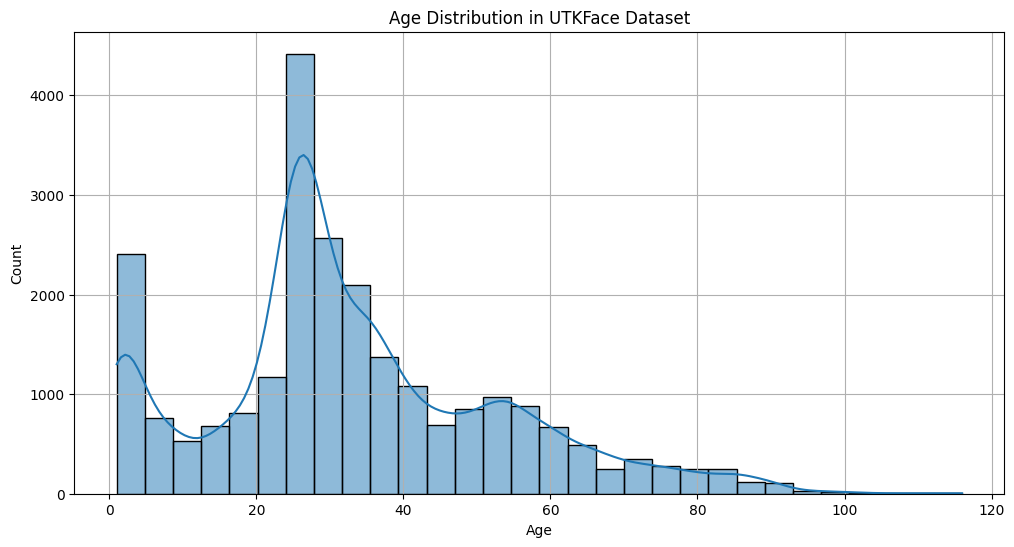

Age statistics:
count    24102.000000
mean        33.041781
std         20.138950
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [10]:
# Plot age distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution in UTKFace Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Age statistics
print("Age statistics:")
print(df['age'].describe())

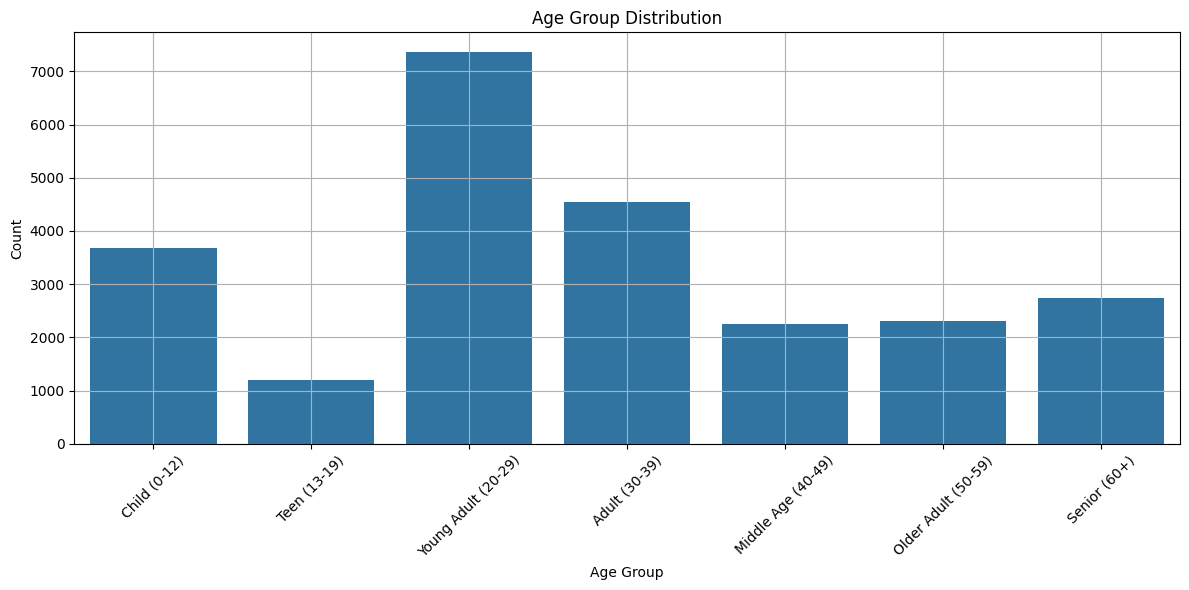

In [11]:
# Create age groups for better analysis
def age_group(age):
    if age < 13:
        return 'Child (0-12)'
    elif age < 20:
        return 'Teen (13-19)'
    elif age < 30:
        return 'Young Adult (20-29)'
    elif age < 40:
        return 'Adult (30-39)'
    elif age < 50:
        return 'Middle Age (40-49)'
    elif age < 60:
        return 'Older Adult (50-59)'
    else:
        return 'Senior (60+)'

df['age_group'] = df['age'].apply(age_group)

# Plot age group distribution
plt.figure(figsize=(12, 6))
order = ['Child (0-12)', 'Teen (13-19)', 'Young Adult (20-29)', 'Adult (30-39)', 
         'Middle Age (40-49)', 'Older Adult (50-59)', 'Senior (60+)']
sns.countplot(x='age_group', data=df, order=order)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Gender Distribution Analysis 

Now let's analyze gender distribution and its relationship with age

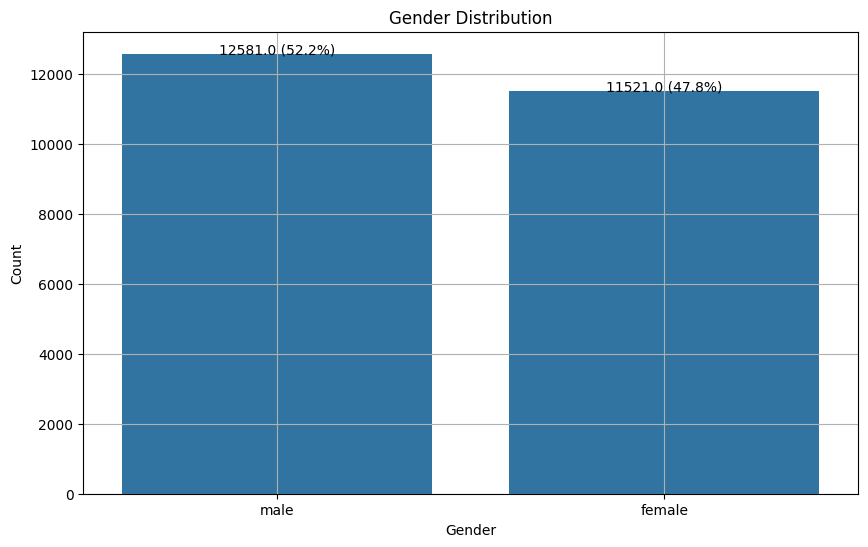

In [12]:
# Plot gender distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)

# Add percentage labels
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2.,
                   height + 5,
                   f'{height} ({100 * height / total:.1f}%)',
                   ha="center") 

plt.show()

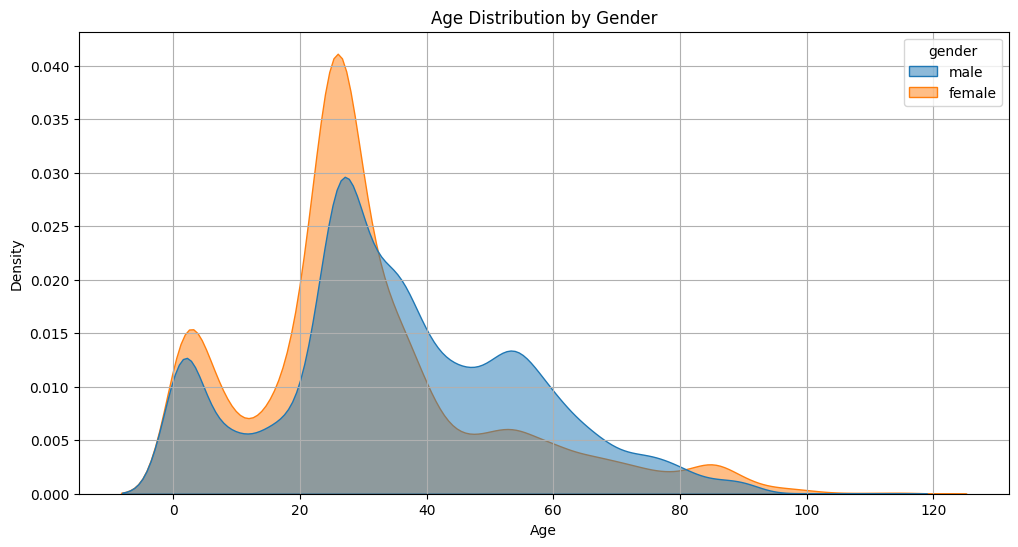

<Figure size 1400x600 with 0 Axes>

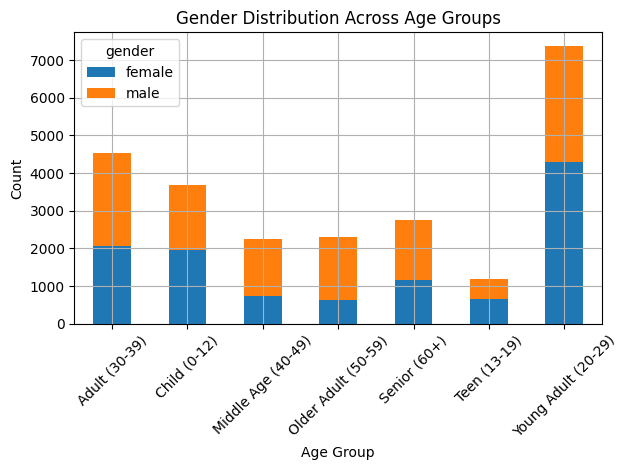

In [13]:
# Plot age distribution by gender
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='age', hue='gender', common_norm=False, fill=True, alpha=0.5)
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Gender distribution across age groups
plt.figure(figsize=(14, 6))
gender_age_counts = df.groupby(['age_group', 'gender']).size().unstack()
gender_age_counts.plot(kind='bar', stacked=True)
plt.title('Gender Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Face Detection

Let's test face detection on some sample images

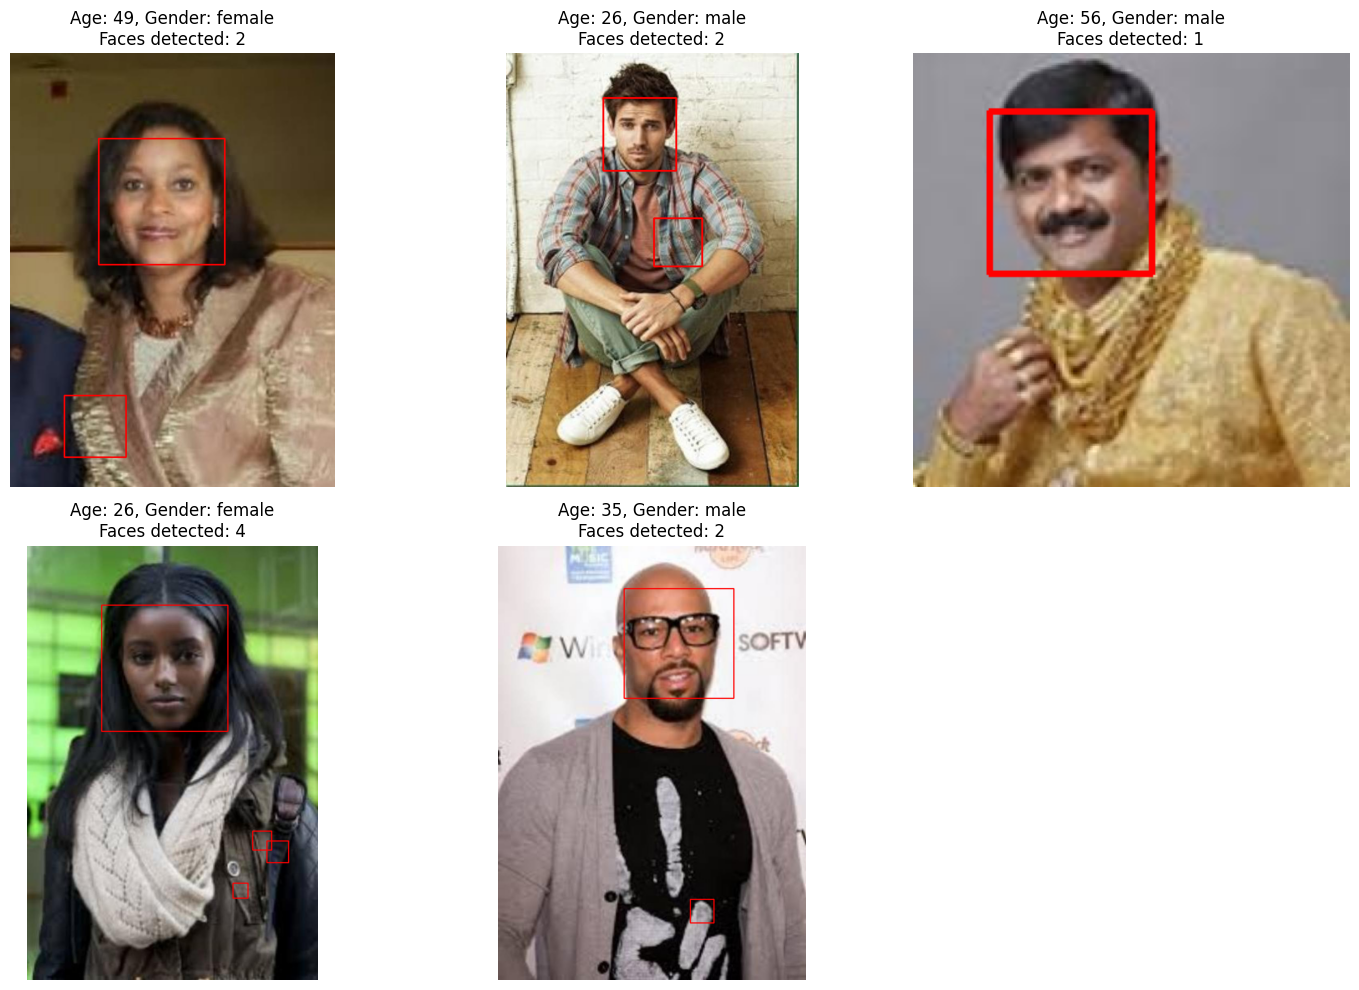

In [14]:
# Load the face detection classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image
def detect_faces(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    # Draw rectangles around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    return img_rgb, faces

# Test on a few sample images
sample_indices = np.random.randint(0, len(df), 5)
sample_images = df.iloc[sample_indices]['path'].tolist()

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(sample_images):
    # Get original labels
    labels = df[df['path'] == img_path].iloc[0]
    age, gender = labels['age'], labels['gender']
    
    # Detect faces
    result_img, faces = detect_faces(img_path)
    
    # Display results
    plt.subplot(2, 3, i+1)
    plt.imshow(result_img)
    plt.title(f"Age: {age}, Gender: {gender}\nFaces detected: {len(faces)}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 7. Preprocessing Functions 

Let's implement preprocessing functions for preparing data for model training

In [15]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(200, 200)):
    # Read image
    img = cv2.imread(image_path)
    
    # Convert to RGB (our model will expect RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize to target size
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values to [0, 1]
    img = img / 255.0
    
    return img

# Function to create a dataset for age prediction
def create_age_dataset(df, target_size=(200, 200), test_size=0.2, max_samples=None):
    # Shuffle the dataframe
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Limit the number of samples if specified
    if max_samples and max_samples < len(df):
        df = df.iloc[:max_samples]
    
    # Split into train and test sets
    train_df = df.iloc[:int(len(df) * (1 - test_size))]
    test_df = df.iloc[int(len(df) * (1 - test_size)):]
    
    print(f"Training samples: {len(train_df)}")
    print(f"Testing samples: {len(test_df)}")
    
    # Create arrays for images and labels
    X_train = np.array([preprocess_image(path, target_size) for path in tqdm(train_df['path'])])
    y_train = np.array(train_df['age'])
    
    X_test = np.array([preprocess_image(path, target_size) for path in tqdm(test_df['path'])])
    y_test = np.array(test_df['age'])
    
    return (X_train, y_train), (X_test, y_test)

# Function to create a dataset for gender prediction
def create_gender_dataset(df, target_size=(200, 200), test_size=0.2, max_samples=None):
    # Shuffle the dataframe
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Limit the number of samples if specified
    if max_samples and max_samples < len(df):
        df = df.iloc[:max_samples]
    
    # Convert gender to binary
    df['gender_binary'] = df['gender'].apply(lambda x: 1 if x == 'female' else 0)
    
    # Split into train and test sets
    train_df = df.iloc[:int(len(df) * (1 - test_size))]
    test_df = df.iloc[int(len(df) * (1 - test_size)):]
    
    print(f"Training samples: {len(train_df)}")
    print(f"Testing samples: {len(test_df)}")
    
    # Create arrays for images and labels
    X_train = np.array([preprocess_image(path, target_size) for path in tqdm(train_df['path'])])
    y_train = np.array(train_df['gender_binary'])
    
    X_test = np.array([preprocess_image(path, target_size) for path in tqdm(test_df['path'])])
    y_test = np.array(test_df['gender_binary'])
    
    return (X_train, y_train), (X_test, y_test)

In [16]:
# Test preprocessing on a small subset
small_df = df.sample(10, random_state=42)

# Create a small age dataset
print("Creating small age dataset:")
(X_age_train, y_age_train), (X_age_test, y_age_test) = create_age_dataset(small_df, max_samples=10)

# Create a small gender dataset
print("\nCreating small gender dataset:")
(X_gender_train, y_gender_train), (X_gender_test, y_gender_test) = create_gender_dataset(small_df, max_samples=10)

# Display shapes
print("\nAge dataset shapes:")
print(f"X_train: {X_age_train.shape}, y_train: {y_age_train.shape}")
print(f"X_test: {X_age_test.shape}, y_test: {y_age_test.shape}")

print("\nGender dataset shapes:")
print(f"X_train: {X_gender_train.shape}, y_train: {y_gender_train.shape}")
print(f"X_test: {X_gender_test.shape}, y_test: {y_gender_test.shape}")

Creating small age dataset:
Training samples: 8
Testing samples: 2


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Creating small gender dataset:
Training samples: 8
Testing samples: 2


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Age dataset shapes:
X_train: (8, 200, 200, 3), y_train: (8,)
X_test: (2, 200, 200, 3), y_test: (2,)

Gender dataset shapes:
X_train: (8, 200, 200, 3), y_train: (8,)
X_test: (2, 200, 200, 3), y_test: (2,)


## 8. Conclusion 

In this notebook, we've explored the UTKFace dataset and prepared preprocessing functions for the face detection and age/gender classification models.

Here's a summary of our findings:

1. The dataset contains facial images with age, gender, and race labels
2. Age distribution is skewed towards younger individuals
3. There's a slight gender imbalance that should be addressed during training
4. We've tested the OpenCV face detection which works well on the dataset
5. Preprocessing functions for age and gender prediction are ready for model training

### Next Steps

In the next notebook, we'll build and train the age and gender models using the preprocessing functions defined here. We'll use deep learning techniques with TensorFlow to create models that can accurately predict a user's age and gender from facial images.